In [1]:
# Import and set up basic packages
import numpy as np

import pandas as pd
pd.options.mode.copy_on_write = True

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 10}) #Basic set up of matplotlib figure and font's size
plt.rcParams["figure.figsize"] = [10, 7]

# Import tools
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Import models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', ValueWarning)


# Build Model

## Split

In [22]:
# Split
y = df['#Passengers']
cutoff_split = int(len(y)*0.8)
y_train = y.iloc[:cutoff_split]
y_test = y.iloc[cutoff_split:]

## Baseline

In [23]:
# Base MSE
y_pred_baseline = [y_train.mean()]*len(y_train)
y_train_mse = mean_squared_error(y_train, y_pred_baseline)
print(f'Base MSE: {y_train_mse}')

Base MSE: 8271.858147448016


## Iterate

In [24]:
# Find the best parameters using Auto Arima
arima = auto_arima(y_train,
                   start_p=0, max_p= 3,
                   d=1, max_d= 1,
                   start_q=0, max_q= 3,
                   start_P=0, max_P= 3,
                   D=1,max_D= 1,
                   start_Q=0, max_Q= 3,
                   m=12,
                   seasonal=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=False,
                   n_fits=100,
                   trace=True
                   )

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.37 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.49 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.13 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.59 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=1.70 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.33 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.17 sec
 ARIMA(0,1,1)(0,1,0)[1

In [25]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Wed, 09 Aug 2023   AIC                            752.557
Time:                                            09:17:21   BIC                            768.307
Sample:                                        01-01-1949   HQIC                           758.934
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

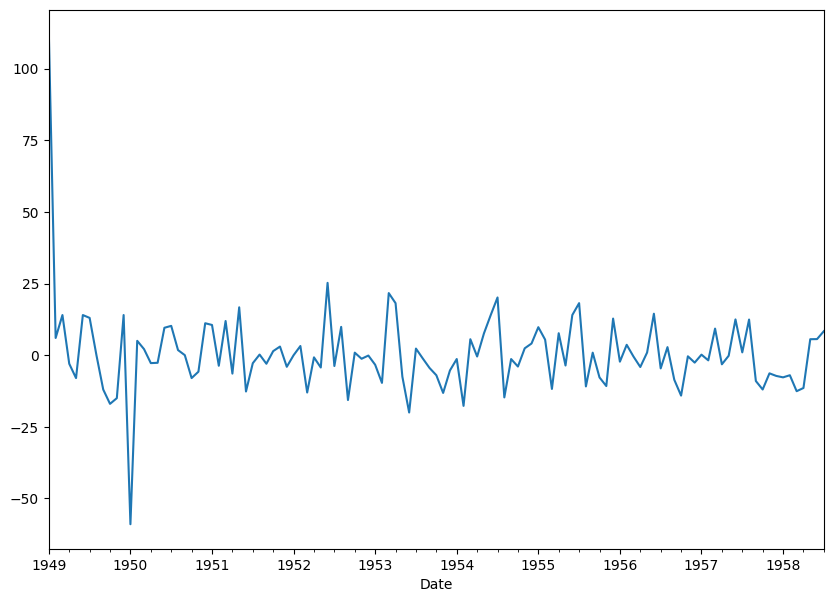

In [26]:
# Plot residuals to check for trends or patterns
arima.resid().plot(xlabel='Date')

The residuals plot looks good as there is no trend or patterns.

## Evaluate

In [27]:
# Rolling validation (walk-forward validation)
test_size = int(len(y_test))
prediction = []
for i in range(test_size):
    train = y.iloc[:-(test_size-i)]
    model = SARIMAX(train, order=(1,1,0), seasonal_order=(1,1,3,12)).fit()
    next_pred = model.forecast(steps=1)
    prediction.append(next_pred.iloc[0])

y_wfv = pd.Series(prediction, index=y_test.index)
y_wfv.head()

Month
1958-08-01    484.734662
1958-09-01    438.096365
1958-10-01    355.588462
1958-11-01    311.154844
1958-12-01    346.299850
dtype: float64

In [28]:
# Comparison between Baseline model's MSE and Test's MSE
print(f'Base MSE: {round(y_train_mse, 2)}')

y_wfv_mse = mean_squared_error(y_test, y_wfv)
print(f'Test MSE: {round(y_wfv_mse, 2)}')

Base MSE: 8271.86
Test MSE: 295.92


# Communicate Results

In [29]:
# Create a DataFrame from y_test and y_wfv for easier comparison
y_test_and_pred = pd.DataFrame({
    'y_test': y_test,
    'y_wfv': y_wfv,
})
y_test_and_pred.head()

,y_test,y_wfv
Month,,
1958-08-01,505,484.734662
1958-09-01,404,438.096365
1958-10-01,359,355.588462
1958-11-01,310,311.154844
1958-12-01,337,346.299850


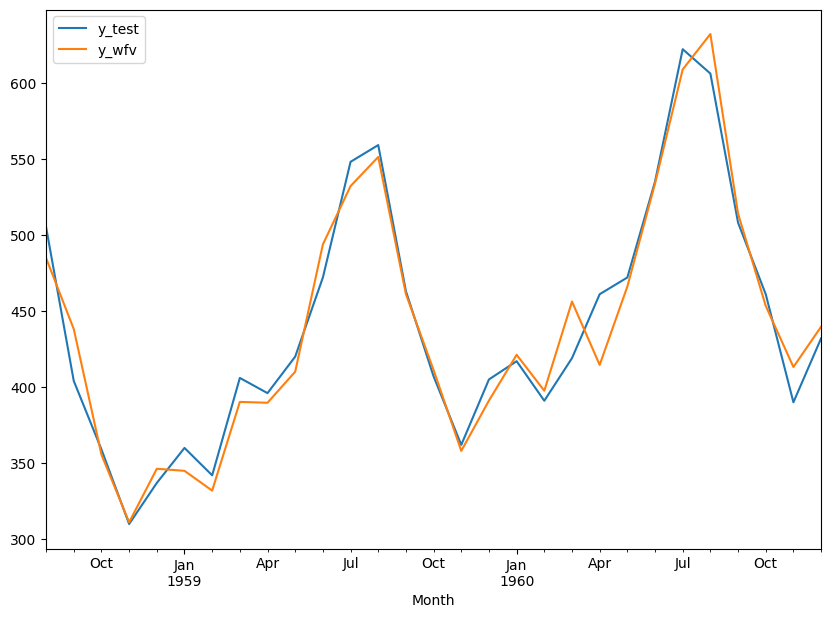

In [30]:
# Visual comparison of y_test and y_wfv
y_test_and_pred.plot()
plt.legend(loc='upper left');

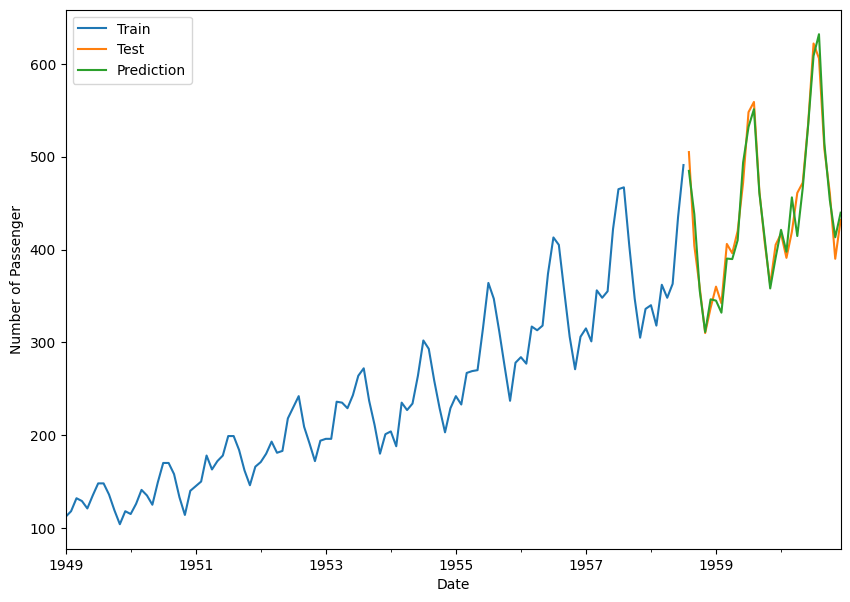

In [31]:
# Visualization of true data and model's prediction
plt.figure()
y_train.plot(label='Train')
y_test.plot(label='Test')
y_wfv.plot(label='Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Passenger')
plt.legend();

# Save, Load, and Test Model

In [32]:
# Save model
model = SARIMAX(y_train, order=(1,1,0), seasonal_order=(1,1,3,12)).fit()
modelname = 'air_passenger_SARIMAX.pkl'
joblib.dump(model, modelname)

['air_passenger_SARIMAX.pkl']

In [33]:
# Load model
modelname = 'air_passenger_SARIMAX.pkl'
sarima_model = joblib.load(modelname)

In [34]:
# Test model
import datetime as dt
today = dt.datetime.now()
last_month = today - dt.timedelta(days=30)

from ts_predictor import Air_Passenger_Predictor # Load the predictor that we have defined in predictor.py
Air_Passenger_Predictor(modelname, last_month, today, return_series=True)

2023-08-01    1750.409556
2023-09-01    1607.883091
Freq: MS, Name: predicted_mean, dtype: float64